# Example Notebook for the tunneling Fermions

This Notebook is based on the following [paper](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.114.080402) from the Jochim group.

In [4]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

In [5]:
from pennylane_ls import *
from heroku_credentials import username, password

In [6]:
FermionDevice = qml.device("synqs.fs",shots=500, username = username, password = password)

In the experiments two Fermions are loaded onto the right side, i.e. into the wire 0 and 1. 

## No interaction
In a first set of experiments there are no interactions and the two atoms are simply allowed to hop.

In [7]:
@qml.qnode(FermionDevice)
def simple_hopping(theta = 0):
    '''
    The circuit that simulates the experiments.
    
    theta ... angle of the hopping
    '''
    # load atoms
    FermionOps.Load(wires=0)
    FermionOps.Load(wires=1)
    
    # let them hop
    FermionOps.Hop(theta, wires=[0,1,2,3])

    # measure the occupation on the right side
    return [qml.expval(FermionOps.ParticleNumber(0)), qml.expval(FermionOps.ParticleNumber(1))]

In [8]:
simple_hopping(0)

tensor([1., 1.], requires_grad=True)

In [9]:
print(simple_hopping.draw())

 0: ──Load──╭Hop(0)──┤ ⟨ParticleNumber⟩ 
 1: ──Load──├Hop(0)──┤ ⟨ParticleNumber⟩ 
 2: ────────├Hop(0)──┤                  
 3: ────────╰Hop(0)──┤                  



In [10]:
Ntimes = 15;
times = np.linspace(0, 20, Ntimes)*1e-3;
J =2*np.pi*134/2;
means = np.zeros((2,Ntimes));
for i in range(Ntimes):
    if i%10==0:
        print("step", i)
    # Calculate the resulting states after each rotation
    means[:,i] = simple_hopping(J*times[i])

step 0
step 10


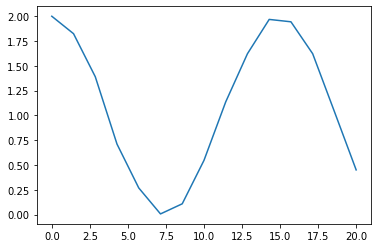

In [11]:
f, ax = plt.subplots()
ax.plot(times*1e3, means.sum(axis=0))

## Hopping with interactions

In a next step the atoms are interacting.

In [12]:
@qml.qnode(FermionDevice)
def correlated_hopping(theta = 0, gamma=0, Ntrott = 5):
    '''
    The circuit that simulates the experiments.
    
    theta ... angle of the hopping
    gamma ... angle of the interaction
    '''
    # load atoms
    FermionOps.Load(wires=0)
    FermionOps.Load(wires=1)
    
    # let them hop
    # evolution under the Hamiltonian
    for ii in range(Ntrott):
        FermionOps.Hop(theta/Ntrott, wires=[0,1,2,3])
        FermionOps.Inter(gamma/Ntrott, wires=[0,1,2,3,4,5,6,7])

    # measure the occupation on the right side
    return [qml.expval(FermionOps.ParticleNumber(0)), qml.expval(FermionOps.ParticleNumber(1))]

In [13]:
correlated_hopping(0.3, 0.4)
print(correlated_hopping.draw())

 0: ──Load──╭Hop(0.06)──╭Inter(0.08)──╭Hop(0.06)──╭Inter(0.08)──╭Hop(0.06)──╭Inter(0.08)──╭Hop(0.06)──╭Inter(0.08)──╭Hop(0.06)──╭Inter(0.08)──┤ ⟨ParticleNumber⟩ 
 1: ──Load──├Hop(0.06)──├Inter(0.08)──├Hop(0.06)──├Inter(0.08)──├Hop(0.06)──├Inter(0.08)──├Hop(0.06)──├Inter(0.08)──├Hop(0.06)──├Inter(0.08)──┤ ⟨ParticleNumber⟩ 
 2: ────────├Hop(0.06)──├Inter(0.08)──├Hop(0.06)──├Inter(0.08)──├Hop(0.06)──├Inter(0.08)──├Hop(0.06)──├Inter(0.08)──├Hop(0.06)──├Inter(0.08)──┤                  
 3: ────────╰Hop(0.06)──├Inter(0.08)──╰Hop(0.06)──├Inter(0.08)──╰Hop(0.06)──├Inter(0.08)──╰Hop(0.06)──├Inter(0.08)──╰Hop(0.06)──├Inter(0.08)──┤                  
 4: ────────────────────├Inter(0.08)──────────────├Inter(0.08)──────────────├Inter(0.08)──────────────├Inter(0.08)──────────────├Inter(0.08)──┤                  
 5: ────────────────────├Inter(0.08)──────────────├Inter(0.08)──────────────├Inter(0.08)──────────────├Inter(0.08)──────────────├Inter(0.08)──┤                  
 6: ────────────────────├Int

In [14]:
Ntimes = 15;
times = np.linspace(0, 20, Ntimes)*1e-3;
J =2*np.pi*134/2;
U = J;
means_int = np.zeros((2,Ntimes));
for i in range(Ntimes):
    if i%10==0:
        print("step", i)
    means_int[:,i] = correlated_hopping(J*times[i], U*times[i])

step 0
step 10


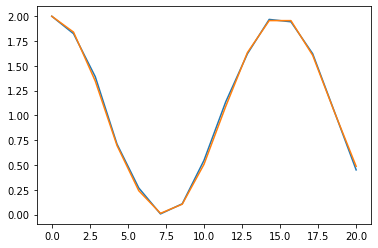

In [15]:
f, ax = plt.subplots()
ax.plot(times*1e3, means.sum(axis=0))
ax.plot(times*1e3, means_int.sum(axis=0))